In [1]:
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import pandas as pd

In [2]:
def get_distances(X1, X2):
    """
    Euclidian distance between vector of points
    """
    diff = X1 - X2
    r2 = np.sum(diff**2, 1)
    return np.sqrt(r2)

def model_error(X, X_pred):
    """
    The error induced by clustering is measured as the sum of the distances of each point in to its cluster
    centre.
    The error on the output prediction might actually different, it depends on the course of MD simulation,
    hence not accessible. Is this OK??
    """
    return np.sum(get_distances(X, X_pred))

def cpu_cost(n_clusters, cpu_penalty):
    """
    CPU cost is assumed directly proportional to the number of MD simulations to perform,
    that is 1 per cluster.
    """
    return n_clusters * cpu_penalty

def find_real_centres(cluster_centres, X, labels):
    """
    We can't perform the MD simulation of the configuration associated with a cluster centre,
    therefore, we find the nearest point in each cluster to the cluster centre.
    The point is used to represent all the other points in the cluster.
    X_pred returns the point that will be used to represnt each point in X.
    """
    real_centres = np.empty(cluster_centres.shape)
    for label, cluster in enumerate(cluster_centres):
        distances = abs(X - cluster)
        closest_arg = np.argmin(np.sum(distances, 1))
        #print(cluster, labels[closest_arg], distances[closest_arg])
        assert labels[closest_arg] == label
        real_centres[label] = X[closest_arg]

    X_pred = np.empty(X.shape)
    for i in range(len(X)):
        X_pred[i] = real_centres[labels[i]]
    return X_pred

In [3]:
# Performa k-means clustering on X, shape=(n_samples, n_freatures)
def cluster(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    X_pred = find_real_centres(kmeans.cluster_centers_, X, kmeans.labels_)
    return X_pred, kmeans

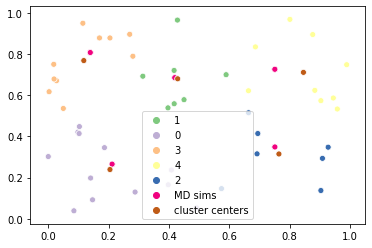

In [4]:
# Graph shows 50 2d-points grouped in 5 clusters by KMeans.
# The KMeans centroid is the centre (in brown) of each cluster (numbered from 0 to 4).
# The configuration corresponding to the centroid cannot be simulated because its prior states are not accessible,
# and are required for the MD simulation.
# We pick the point from the dataset in each cluster closest to the centre to represent the cluster (in pink),
# when dealing with MD simulations, this point would be the configuration to simulate.

np.random.seed(1)
npoints = 50
d = 2 # dimensions
X = np.random.random((npoints, d))
n_clusters = 5

X_pred, kmeans = cluster(X, n_clusters)

x = np.concatenate((X[:,0], X_pred[:,0], kmeans.cluster_centers_[:,0]))
y = np.concatenate((X[:,1], X_pred[:,1], kmeans.cluster_centers_[:,1]))
labels = np.concatenate((kmeans.labels_, ['MD sims']*len(X_pred), ['cluster centers']*len(kmeans.cluster_centers_)))

sns.scatterplot(x=x, y=y, hue=labels, palette='Accent')

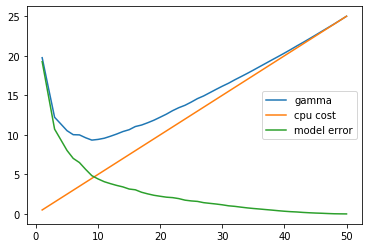

In [26]:
# A similar setup (50 2d-points) is clustered for an increasing number of clusters.
# For each number of clusters, the cpu cost is assessed (proportional to the number of cluster)
# as well as the error (induced by the parameter space reduction)
# I have plotted the trade off in model error and cpu cost (varying the number of clusters)

np.random.seed(1)
cpu_penalty = 0.5
X = np.random.random((npoints, d))
n_clusters = list(range(1,51))
cpu_costs = []
model_errors = []

for n in n_clusters:
    X_pred, kmeans = cluster(X, n)
    cpu_costs += [ cpu_cost(n, cpu_penalty) ]
    model_errors += [ model_error(X, X_pred )]

total = np.array(cpu_costs) + np.array(model_errors)
ax = sns.lineplot(x=n_clusters, y=total, label='gamma')
ax = sns.lineplot(x=n_clusters, y=cpu_costs, label='cpu cost')
ax = sns.lineplot(x=n_clusters, y=model_errors, label='model error')

In [27]:
# Clustering is performed for an evolving system. The initial system is similar to the previous one (50 2d-points).
# At each step of the evolution, the points are spread out linearly (?), and the optimum number of clusters
# is sought, assuming best cpu cost to error trade-off (minimization of 'gamma'='cpu cost'+'error').
# The optimum number of clusters, its associated cpu cost, error and gamma are plotted versus for each step
# (also equivalent to the spreading factor).

np.random.seed(2)

cpu_penalty = 2
max_error = 30
nsteps = 20
npoints = 50
d = 2 # dimensions

T = np.arange(1, nsteps+1) # time series

# points to cluster, more spread out over time
x = np.random.random((npoints, d))
x = np.repeat(x[np.newaxis,:,:], nsteps, axis=0)
## Below, are you multiplying the position of the points by the time/step value in order to spread the points out?
x *= T[:, np.newaxis, np.newaxis] 

errors = []
gammas = []
clusters = []

for X, t in zip(x, T):
    optimum_clusters = 0
    optimum_gamma = np.inf
    optimum_error = np.inf

    for n_clusters in range(1, npoints+1):
        X_pred, kmeans = cluster(X, n_clusters)
        
        error = model_error(X, X_pred)
        penalty = cpu_cost(n_clusters, cpu_penalty)
        gamma = error + penalty
            
        if gamma < optimum_gamma:
            # best clustering found so far
            optimum_clusters = n_clusters
            optimum_gamma = gamma
            optimum_error = error
            
    gammas += [optimum_gamma]
    clusters += [optimum_clusters]
    errors += [optimum_error]
            
    print(t, optimum_clusters)

1 3
2 6
3 6
4 6
5 10
6 11
7 12
8 14
9 15
10 15
11 16
12 16
13 19
14 19
15 19
16 19
17 19
18 27
19 27
20 27


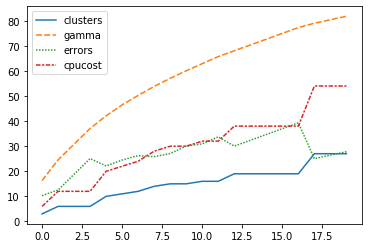

In [28]:
a = pd.DataFrame({'x':T, 'clusters': clusters, 
                  'gamma':gammas, 'errors':errors})
a['cpucost'] = a['gamma'] - a['errors']
ax = sns.lineplot(data=a)